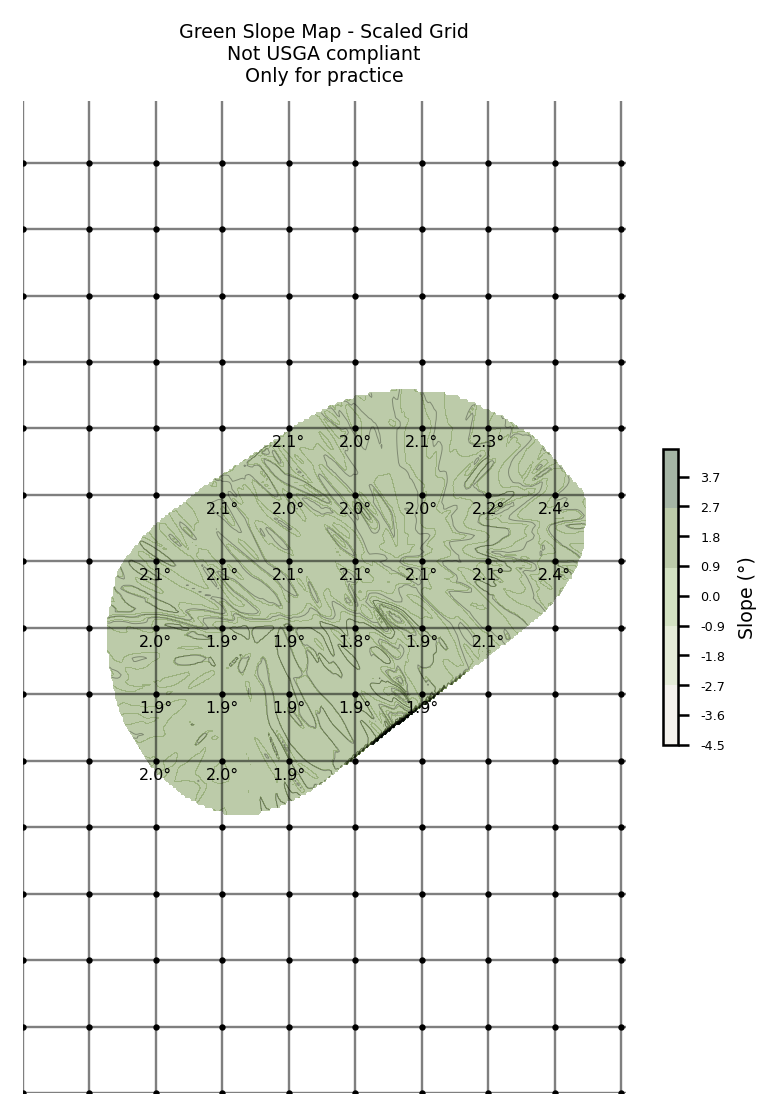

In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import griddata
from pyproj import Transformer

# Constants
PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375
my_dpi = 228.71

GRID_SPACING_METERS = 4.572
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES

def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)

def calculate_slope(grid_y, grid_x, grid_elev):
    dy, dx = np.gradient(grid_elev, np.mean(np.diff(grid_y[:, 0])), np.mean(np.diff(grid_x[0, :])))
    slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))  # in radians
    slope_degrees = np.degrees(slope_radians)         # convert to degrees
    return slope_degrees

from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

def plot_slope_map(grid_x, grid_y, slope_degrees, page_width_m, page_height_m, zoom_factor):
    
    # Define the custom colormap
    #custom_colors = ['#259c36cc', '#addf17cc', '#dfce17cc']
    #cmap = LinearSegmentedColormap.from_list('custom_earth_tone', custom_colors)
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

      # === NEW: black contour lines (on slope field). You can swap slope_degrees for grid_elev if you prefer elevation contours.
    ax.contour(grid_x, grid_y, slope_degrees, levels=np.arange(0.0, 4.6, 0.1),
               colors='black', linewidths=0.3, alpha=0.33)

    # Restrict colormap display to slope range between -4.5 and 4.5 degrees
    levels = np.linspace(-4.5, 4.5, 150)
    slope_plot = ax.contourf(grid_x, grid_y, slope_degrees, cmap=cmap, levels=levels, alpha=.5)

    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', format='%.1f', shrink=0.24)
    cbar.ax.tick_params(labelsize=4)
    cbar.set_label('Slope (°)', fontsize=6)

    ax.set_title('Green Slope Map - Scaled Grid\nNot USGA compliant\nOnly for practice', fontsize=6)
    ax.set_aspect('equal')
    ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            ax.plot(x, y, 'ko', markersize=1)
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_degrees[idx]
            if not np.isnan(slope_val) and -4.5 <= slope_val <= 4.5:
                ax.text(x, y - adjusted_grid_spacing_meters * 0.1,
                        f'{slope_val:.1f}°', color='black', fontsize=5, ha='center', va='top')

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)

    plt.show()


def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1

def main(gpx_file_path):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)
    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 300
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')

    slope_degrees = calculate_slope(grid_y, grid_x, grid_elev)

    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    plot_slope_map(grid_x_shifted, grid_y_shifted, slope_degrees, page_width_m, page_height_m, zoom_factor)

# Example usage
gpx_file = '/Users/joshh./Downloads/course_mapping_project/course_data_gpx/GCSATX_green_1.gpx'
main(gpx_file)

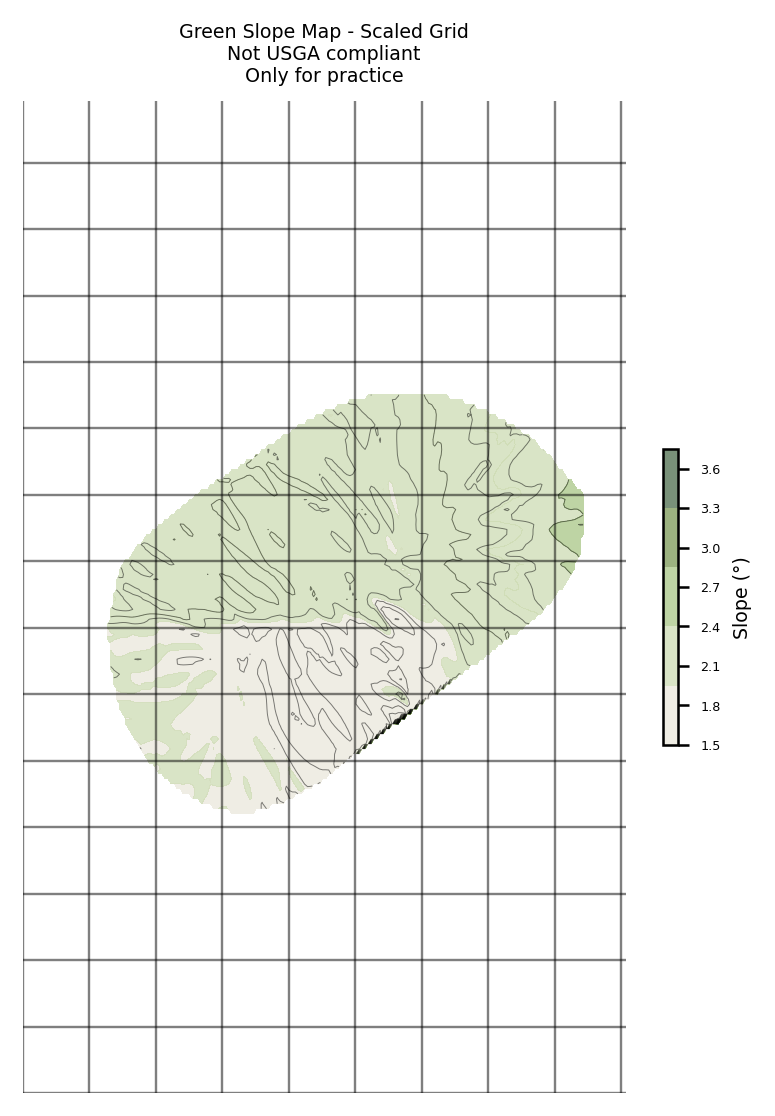

In [4]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import griddata
from pyproj import Transformer

PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375
my_dpi = 228.71

GRID_SPACING_METERS = 4.572
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES

def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)

def calculate_slope_and_aspect(grid_y, grid_x, grid_elev):
    # spacing in meters along Y and X (you already pass physical spacing to np.gradient)
    dy_m = np.mean(np.diff(grid_y[:, 0]))
    dx_m = np.mean(np.diff(grid_x[0, :]))

    # gradients of elevation (dz/dy, dz/dx) -> point UPSLOPE
    dz_dy, dz_dx = np.gradient(grid_elev, dy_m, dx_m)

    # slope magnitude (rise/run) → degrees
    rise_over_run = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.degrees(np.arctan(rise_over_run))

    # aspect (downslope direction): use the NEGATIVE gradient
    aspect_downslope = np.arctan2(-dz_dy, -dz_dx)

    return slope_degrees, aspect_downslope


def plot_slope_map(grid_x, grid_y, slope_degrees, aspect, page_width_m, page_height_m, zoom_factor):
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # Slope is non-negative; clip/colorbar to your playing range
    #levels = np.linspace(0, 4.5, 200)
    slope_plot = ax.contourf(grid_x, grid_y, slope_degrees, cmap=cmap, levels=15, alpha=.75)

    # === NEW: black contour lines (on slope field). You can swap slope_degrees for grid_elev if you prefer elevation contours.
    ax.contour(grid_x, grid_y, slope_degrees, levels=np.arange(0.0, 4.6, 0.1),
               colors='black', linewidths=0.3, alpha=0.5)

    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', format='%.1f', shrink=0.24)
    cbar.ax.tick_params(labelsize=4)
    cbar.set_label('Slope (°)', fontsize=6)

    ax.set_title('Green Slope Map - Scaled Grid\nNot USGA compliant\nOnly for practice', fontsize=6)
    ax.set_aspect('equal'); ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    # grid lines
    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    plt.show()

def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1

def main(gpx_file_path):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)

    if len(longitudes) == 0:
        print("Error: No valid trackpoint data found in GPX file.")
        return

    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 200
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')

    slope_degrees, aspect = calculate_slope_and_aspect(grid_y, grid_x, grid_elev)

    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    plot_slope_map(grid_x_shifted, grid_y_shifted, slope_degrees, aspect, page_width_m, page_height_m, zoom_factor)

gpx_file = '/Users/joshh./Downloads/course_mapping_project/course_data_gpx/GCSATX_green_1.gpx'
main(gpx_file)


## Code for competition and practice versions of the mapping based on user input is below. 

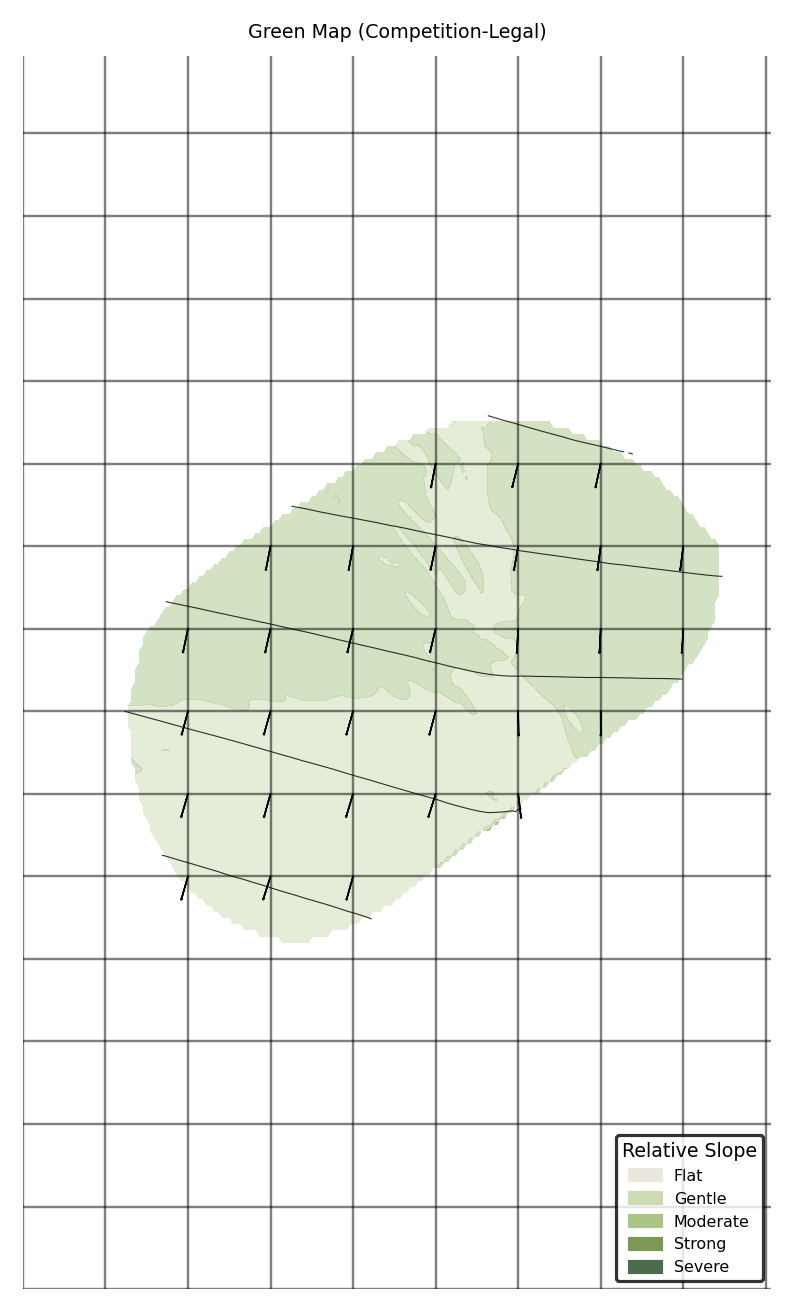

In [5]:


import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import griddata
from pyproj import Transformer

# === PAGE & GRID CONSTANTS (USGA COMPLIANT) ===
PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375          # 3/8" = 15 feet scale
my_dpi = 228.71

GRID_SPACING_METERS = 4.572          # 15 feet per grid
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES


# === GPX PARSER ===
def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)


# === SLOPE AND ASPECT (downslope corrected) ===
def calculate_slope_and_aspect(grid_y, grid_x, grid_elev):
    dy_m = np.mean(np.diff(grid_y[:, 0]))
    dx_m = np.mean(np.diff(grid_x[0, :]))
    dz_dy, dz_dx = np.gradient(grid_elev, dy_m, dx_m)
    slope_rise_over_run = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.degrees(np.arctan(slope_rise_over_run))
    aspect_downslope = np.arctan2(-dz_dy, -dz_dx)
    return slope_degrees, aspect_downslope


# === PRACTICE MAP (detailed slope display) ===
def plot_slope_map_practice(grid_x, grid_y, slope_degrees, aspect,
                            page_width_m, page_height_m, zoom_factor):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # --- match competition-legal greens ---
    slope_capped = np.clip(slope_degrees, 0.0, 4.0)   # keep within legal band
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])           # same bins as legal
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    norm = BoundaryNorm(bounds, len(bounds) - 1)

    # Discrete fill (same look as legal)
    slope_plot = ax.contourf(
        grid_x, grid_y, slope_capped,
        levels=bounds, cmap=cmap, norm=norm, alpha=0.55
    )

    # Optional: black contour lines (keep if you like)
    ax.contour(grid_x, grid_y, slope_capped,
               levels=bounds, colors='black', linewidths=0.3, alpha=0.5)

    # Practice mode can keep a labeled colorbar
    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', shrink=0.24)
    cbar.set_label('Slope (°)', fontsize=6)
    cbar.set_ticks(bounds)
    cbar.ax.tick_params(labelsize=5)

    ax.set_title('Green Slope Map (Practice Mode)', fontsize=6)
    ax.set_aspect('equal')
    ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    # Draw grid
    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    # Downslope arrows with slope text
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_degrees[idx]
            aspect_val = aspect[idx]

            if not np.isnan(slope_val) and 0.0 <= slope_val <= 4.5:
                L = 0.35 * adjusted_grid_spacing_meters
                dx_arrow = np.cos(aspect_val) * L
                dy_arrow = np.sin(aspect_val) * L
                ax.arrow(x, y, dx_arrow, dy_arrow, head_width=0.12, head_length=0.12,
                         fc='black', ec='black', linewidth=0.5, length_includes_head=True)
                ax.text(x, y - adjusted_grid_spacing_meters * 0.10,
                        f'{slope_val:.1f}°', color='black', fontsize=4, ha='center', va='top')

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    plt.show()


# === COMPETITION-LEGAL VERSION (USGA COMPLIANT) ===
def plot_slope_map_legal(grid_x, grid_y, slope_degrees, aspect, page_width_m, page_height_m,
                         zoom_factor, elevation_for_contours, contour_step_ft=1.0,
                         arrow_len_frac=0.30, show_colorbar=False):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # Coarse slope shading capped at 4°
    slope_capped = np.clip(slope_degrees, 0.0, 4.5)
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    shade = ax.contourf(grid_x, grid_y, slope_capped, levels=bounds, cmap=cmap, norm=norm, alpha=0.5)

    if show_colorbar:
        cbar = plt.colorbar(shade, ax=ax, orientation='vertical', shrink=0.28)
        cbar.set_ticks([])
        cbar.set_label('Relative Slope Bands', fontsize=6)

    # Black elevation contours spaced ≥ 1 ft
    ft_to_m = 0.3048
    step_m = max(contour_step_ft, 1.0) * ft_to_m
    vmin, vmax = np.nanmin(elevation_for_contours), np.nanmax(elevation_for_contours)
    start = np.floor(vmin / step_m) * step_m
    levels_m = np.arange(start, vmax + step_m, step_m)

    ax.contour(grid_x, grid_y, elevation_for_contours,
               levels=levels_m, colors='black', linewidths=0.35, alpha=0.8)

    # Draw page grid
    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    # Downslope arrows only
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_capped[idx]
            aspect_val = aspect[idx]
            if not np.isnan(slope_val) and slope_val >= 0.0:
                L = arrow_len_frac * adjusted_grid_spacing_meters
                ax.arrow(x, y, np.cos(aspect_val) * L, np.sin(aspect_val) * L,
                         head_width=0.10, head_length=0.10, fc='black', ec='black',
                         linewidth=0.5, length_includes_head=True)

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Green Map (Competition-Legal)', fontsize=6)
    from matplotlib.patches import Patch
    legend_colors = ["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"] #legend_colors = ["#0099ff", "#00ff99", "#ffff00", "#ff9900", "#ff0000"]
    legend_labels = ["Flat", "Gentle", "Moderate", "Strong", "Severe"]
    legend_patches = [Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]
    ax.legend(
        handles=legend_patches,
        title="Relative Slope",
        loc="lower right",
        fontsize=5,
        title_fontsize=6,
        frameon=True,
        edgecolor='black'
    )
    plt.show()


# === COORDINATE SYSTEM UTILITIES ===
def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1


# === MAIN FUNCTION ===
def main(gpx_file_path, competition_legal=False):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)
    if len(longitudes) == 0:
        print("Error: No valid trackpoint data found in GPX file.")
        return

    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 200
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')
    slope_degrees, aspect = calculate_slope_and_aspect(grid_y, grid_x, grid_elev)
    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    if competition_legal:
        plot_slope_map_legal(grid_x_shifted, grid_y_shifted, slope_degrees, aspect,
                             page_width_m, page_height_m, zoom_factor,
                             elevation_for_contours=grid_elev, contour_step_ft=1.0)
    else:
        plot_slope_map_practice(grid_x_shifted, grid_y_shifted, slope_degrees, aspect,
                                page_width_m, page_height_m, zoom_factor)


# === ENTRY POINT ===
if __name__ == "__main__":
    gpx_file = "/Users/joshh./Downloads/course_mapping_project/course_data_gpx/GCSATX_green_1.gpx"  # replace with your GPX path
    legal_mode = input("Competition legal mode? (y/n): ").strip().lower() == "y"
    main(gpx_file, competition_legal=legal_mode)
